In [1]:
import numpy as np
import pandas as pd
import torch
import sklearn
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as du
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.manifold import TSNE
from tqdm import tqdm
from torch.utils import data
from collections import defaultdict
from torch.utils.data import Dataset
from torchvision import datasets, transforms

In [2]:
#Obtain student data from the github
url_student = 'https://raw.githubusercontent.com/Instantutor/Instantutor-Research/main/Datasets/Data.csv'
student = pd.read_csv(url_student)

#Take a look at the first 5 rows
student.head()

,id_student,gender,Category(Mentor/Mentee/Both),Area,Degree,Course,Time zone,Availability time start,Availability time end
0,11391,M,1,IT,Undergraduate,NaN,Asia,9:00,14:00
1,28400,F,3,IT,Graduate,NaN,Pacific,16:00,18:00
2,30268,F,2,IT,PhD,NaN,Europe,12:00,15:00
3,31604,F,1,IT,PhD,NaN,Central,14:00,23:00
4,32885,F,3,IT,Undergraduate,NaN,Europe,20:00,23:00


In [3]:
#Drop unnecessary info, for now, we will drop course. In the future, we can simply do a dot product of course and a tutor's speciality.
student.drop(['Category(Mentor/Mentee/Both)', 'Degree', 'Course'], axis = 1, inplace = True)
student.head()

,id_student,gender,Area,Time zone,Availability time start,Availability time end
0,11391,M,IT,Asia,9:00,14:00
1,28400,F,IT,Pacific,16:00,18:00
2,30268,F,IT,Europe,12:00,15:00
3,31604,F,IT,Central,14:00,23:00
4,32885,F,IT,Europe,20:00,23:00


In [4]:
#Obtain rating data from the github
url_rating = 'https://raw.githubusercontent.com/Instantutor/Instantutor-Research/main/Datasets/Rating.csv'
rating = pd.read_csv(url_rating)

#Take a look at the first 5 rows
rating.head()

,Mentor,Mentee,Rating,Comments,Time stamp
0,366449,NaN,1.0,NaN,1425941529
1,1677677,NaN,4.5,NaN,1425942435
2,553755,NaN,5.0,NaN,1425941523
3,611182,NaN,5.0,NaN,1425941546
4,646184,NaN,5.0,NaN,1425941556


In [5]:
#Drop Unnecessary Information, in the future we can find do sentiment analysis on comments to create a +- value.
rating.drop(['Mentee', 'Time stamp', 'Comments'], axis = 1, inplace = True)
rating.head()

,Mentor,Rating
0,366449,1.0
1,1677677,4.5
2,553755,5.0
3,611182,5.0
4,646184,5.0


In [6]:
#View the Distribution of Data
print(student['Area'].value_counts())
print(student['Time zone'].value_counts())

IT                      3338
Chemistry               3299
Math                    3265
Chemical Engineering    3231
Materials Science       3182
History                 3155
Geology                 3151
Computer Science        3133
Aerospace               3131
Physics                 3114
French                   130
Arabic                   118
Science                  102
English                   90
Biology                   60
Spanish                   50
Quran                     44
Name: Area, dtype: int64
Asia             4162
Europe           4096
Africa           4095
Australia        4082
Pacific          4064
North America    4040
Central          4034
Antarctica       4020
Name: Time zone, dtype: int64


In [7]:
#Obtain all possible labels for each column to be generated
possible_areas = student['Area'].unique()
possible_zones = student['Time zone'].unique()
possible_times = ["0:00", "1:00", "2:00", "3:00", "4:00", "5:00", "6:00", "7:00", "8:00", "9:00", "10:00", "11:00", "12:00", "13:00", "14:00", "15:00", "16:00", "17:00", "18:00", "19:00", "20:00", "21:00", "22:00", "23:00"] 
possible_genders = ['F', 'M']

#3999 rows

student_rows = student['Area'].size
rating_rows = rating['Mentor'].size

#obtain the distribution
spreads = student['Area'].value_counts()
distribution = spreads.div(student_rows)
print(distribution)

IT                      0.102415
Chemistry               0.101218
Math                    0.100175
Chemical Engineering    0.099132
Materials Science       0.097628
History                 0.096800
Geology                 0.096677
Computer Science        0.096125
Aerospace               0.096064
Physics                 0.095542
French                  0.003989
Arabic                  0.003620
Science                 0.003130
English                 0.002761
Biology                 0.001841
Spanish                 0.001534
Quran                   0.001350
Name: Area, dtype: float64


In [8]:
# Only Area generation is weighted. Other data generation will be uniformly distributed.
rating['gender'] = np.random.choice(possible_genders, rating_rows)
rating['Area'] = np.random.choice(possible_areas, rating_rows, p = distribution.values)
rating['Time zone'] = np.random.choice(possible_zones, rating_rows)
rating['Availability time start'] = np.random.choice(possible_times, rating_rows)
rating['Availability time end'] = np.random.choice(possible_times, rating_rows)

#view the new ratings data
rating.head()

,Mentor,Rating,gender,Area,Time zone,Availability time start,Availability time end
0,366449,1.0,F,Spanish,North America,2:00,6:00
1,1677677,4.5,M,French,Europe,3:00,14:00
2,553755,5.0,M,History,Africa,18:00,3:00
3,611182,5.0,F,Math,North America,20:00,14:00
4,646184,5.0,M,Quran,Asia,16:00,9:00


In [9]:
#Since we are only comparing similarity, we can exclude rating from the encoder and simply sort recommended tutors by their rating at the end.

#Store the mentor:rating pairs as a dictionary for future access
Mentor_to_rating = rating.groupby('Mentor')['Rating'].apply(list).to_dict()

#Drop the rating column
rating.drop('Rating', axis = 1, inplace = True)

We will use a classification task to train our embeddings. To do so, we will create positive pairs using collaborative filtering
and randomly sampled negative pairs. For each user, we want to create 3 positive samples and 15 negative samples. We can choose to pass these as batches.

In [10]:
#First, we want to convert the features of each student and tutor to numerical values.
gender_to_val = {possible_genders[i]:i for i in range(len(possible_genders))}
area_to_val = {'IT' : 0, 'Computer Science': 3, 'Math': 9, 'Physics': 11 ,'Aerospace': 13,
               'Science': 20, 'Chemical Engineering': 24, 'Materials Science': 29,
               'Biology': 30, 'Chemistry': 24, 'Geology': 45,
               'English': 68, 'French': 77, 'Spanish': 82,
               'Arabic': 88, 'Quran': 95, 'History': 110}
               
time_to_val = {'Asia': 0, 'Europe': 20, 'Africa': 40, 'Australia': 60, 'Antarctica': 70, 'North America': 80, 'Central': 90, 'Pacific': 100}
avail_to_val = {possible_times[i]:i  for i in range(len(possible_times))}



print(f"Genders: {gender_to_val}\nAreas: {area_to_val}\nTimes: {time_to_val}\nAvailabilities: {avail_to_val}")

Genders: {'F': 0, 'M': 1}
Areas: {'IT': 0, 'Computer Science': 3, 'Math': 9, 'Physics': 11, 'Aerospace': 13, 'Science': 20, 'Chemical Engineering': 24, 'Materials Science': 29, 'Biology': 30, 'Chemistry': 24, 'Geology': 45, 'English': 68, 'French': 77, 'Spanish': 82, 'Arabic': 88, 'Quran': 95, 'History': 110}
Times: {'Asia': 0, 'Europe': 20, 'Africa': 40, 'Australia': 60, 'Antarctica': 70, 'North America': 80, 'Central': 90, 'Pacific': 100}
Availabilities: {'0:00': 0, '1:00': 1, '2:00': 2, '3:00': 3, '4:00': 4, '5:00': 5, '6:00': 6, '7:00': 7, '8:00': 8, '9:00': 9, '10:00': 10, '11:00': 11, '12:00': 12, '13:00': 13, '14:00': 14, '15:00': 15, '16:00': 16, '17:00': 17, '18:00': 18, '19:00': 19, '20:00': 20, '21:00': 21, '22:00': 22, '23:00': 23}


In [11]:
#Replace any non numerical values according to the dictionary.
student = student.replace(gender_to_val)
student = student.replace(area_to_val)
student = student.replace(time_to_val)
student = student.replace(avail_to_val)

#visualize the user data
student.head()

,id_student,gender,Area,Time zone,Availability time start,Availability time end
0,11391,1,0,0,9,14
1,28400,0,0,100,16,18
2,30268,0,0,20,12,15
3,31604,0,0,90,14,23
4,32885,0,0,20,20,23


In [12]:
rating = rating.replace(gender_to_val)
rating = rating.replace(area_to_val)
rating = rating.replace(time_to_val)
rating = rating.replace(avail_to_val)

#visualize the rating data
rating.head()

,Mentor,gender,Area,Time zone,Availability time start,Availability time end
0,366449,0,82,80,2,6
1,1677677,1,77,20,3,14
2,553755,1,110,40,18,3
3,611182,0,9,80,20,14
4,646184,1,95,0,16,9


In [13]:
#Make a mapping of users and tutors to indicies. This way, we can keep track of the books. Also create a reverse mapping.
list_tutors = rating['Mentor'].tolist()
list_users = student['id_student'].tolist()

#create mappings for users
idx_to_user = {index: user for (index, user) in enumerate(list_users)}
user_to_idx = {user: index for (index, user) in enumerate(list_users)}

#create mappings for tutors
idx_to_tutor = {index: tutor for (index, tutor) in enumerate(list_tutors)}
tutor_to_idx = {tutor: index for (index, tutor) in enumerate(list_tutors)}

In [14]:
#We do not want repeat tutors or students to be overrepresented in the current data.
#Remove duplicate student ids or tutor ids.
duplicate_users = student[student.duplicated(subset = 'id_student', keep = 'first')]
duplicate_tutors = rating[rating.duplicated(subset = 'Mentor', keep = 'first')]

#drop the duplicate students and users
student.drop(index = duplicate_users.index, inplace = True)
rating.drop(index = duplicate_tutors.index, inplace = True)

#Since we have a mapping now, we can remove the ids from the dataframe, set inplace to false so that a new copy of the df is made.
final_user = student.drop('id_student', axis = 1, inplace = False)
final_tutor = rating.drop('Mentor', axis = 1, inplace = False)

Then, we can generate positive and negative samples through collaborative filtering.
When selecting positive samples, cosine similarity will be weighted based on the following criteria(Adjustable):
* Gender: 5%
* Area: 65%
* Time Zone: 15%
* Availability Time Start: 10%
* Availability Time End: 5%

In [15]:
weights = [0.05, 0.70, 0.10, 0.10, 0.05]

In [16]:
def weighted_Norm(user, tutor, weights):
    '''
    Calculate a weighted euclidean distance given a user and a tutor.
    Since we are using distance, we can simply set student rating to 1 as default and ratings from 0 to 5 as 0 - 1 respectively.
    '''
    dist = user-tutor
    weighted_dist = np.sqrt(np.dot(weights,np.dot(dist, dist)).sum())
    return weighted_dist

In [17]:
class UserTutorDataset(torch.utils.data.Dataset):
    def __init__(self, pos_samples, neg_samples, users, tutors, weights):
        '''
        pos_samples - The number of positive samples to create per user.
        neg_samples - The number of negative samples to create per user.
        users - A dataset consisting of users and their attributes(gender, area, timezone, availability times).
        tutors - A dataset consisting of tutors and their attributes.
        weights - An array-like of weights for each attribute of a user/tutor. This gives us more information on which attributes are more important.
        '''
        super(UserTutorDataset, self).__init__()
        
        self.pos_samples = pos_samples
        self.neg_samples = neg_samples
        self.users = users
        self.tutors = tutors
        self.weights = weights
        
        #calculate all distances and store in a dictionary.       
        self.dists = {user_idx:[weighted_Norm(self.users[user_idx], tutor, self.weights) for tutor in self.tutors] for user_idx in tqdm(range(len(self.users)))}
        
    def get_pairs(self, user):
        ''' given a user, generate positive and negative pairs for that user '''
        #randomly select 12 from the farthest 2000 as negative. 
        
        #obtain the similarity of the user to every tutor.
        distances = self.dists[user]
        #obtain indicies of the lowest num_pos distances in linear time. (argpartition ensures that all values until the kth value are sorted.)
        pos_pairs = np.argpartition(distances, self.pos_samples)[:self.pos_samples]
        
        #randomly obtain negative samples from the 500 least similiar tutors.
        min_five = np.argpartition(distances, -500)[-500:]
        neg_pairs = np.random.choice(min_five, self.neg_samples)
        
        #generate an array of labels.
        labels = np.zeros(self.pos_samples + self.neg_samples)
        labels[0:self.pos_samples] = 1
        return pos_pairs, neg_pairs, labels
        
    def __len__(self):
        '''
        Return the total number of users.
        '''
        return len(self.users)
    
    def __getitem__(self, idx):
        '''
        Return a tensor of positive and negative tutor samples along with a tensor of targets given a user index.
        '''
        pos_pairs, neg_pairs, labels = self.get_pairs(idx)
        pos_pairs = torch.tensor(pos_pairs)
        neg_pairs = torch.tensor(neg_pairs)
        total_pairs = torch.cat((pos_pairs, neg_pairs), dim = 0)
        labels = torch.tensor(labels)
        
        #create a tensor of targets(user)
        targets = torch.full(total_pairs.shape, idx)
        return targets, total_pairs, labels

In [18]:
def visualize_embeddings(embeddings, feature, rating, embedding_dim, mode):
    '''
    Given a learned embedding, a dataframe, and the feature to display by, 
    display a tsne-visualization of the embeddings and then 
    the embeddings by feature if feature is not none.
    '''
    
    #reduce the embeddings to 2 dimensions using a manifold.
    reduced_embedding = TSNE(3, perplexity = 50, learning_rate = 'auto', init = 'pca', metric = 'euclidean').fit_transform(embeddings)
    
    plt.figure(figsize = (12.4,9.92))
    plt.plot(reduced_embedding[:, 0], reduced_embedding[:, 1], reduced_embedding[:,2], '.g')
    if mode == 'User':
        plt.title("User Embeddings")
    else:
        plt.title("Tutor Embeddings")
    plt.show()
    
    
    if feature != 'None' and feature in rating.columns:
        #obtain all labels for that feature
        plt.figure(figsize = (18,12))
        all_labels = rating[feature]
        color_labels, unique_feats  = pd.factorize(all_labels)
        
        new_colors = plt.cm.tab20(np.linspace(0.0, 1.0, 17))
        new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap", new_colors)

        plt.scatter(reduced_embedding[:, 0], reduced_embedding[:, 1], reduced_embedding[:,2],
                    c = color_labels, cmap = new_cmap)
        
        #show a key on the side
        color_bar = plt.colorbar()
        color_bar.set_ticks([])
        
        for idx, feats in enumerate(unique_feats):
            color_bar.ax.text(1, (2 * idx + 1)/((10)*2), feats, ha = 'left', va = 'center')
        color_bar.ax.set_title(feature, loc = 'left')
        plt.xlabel("Embedding Axis 1")
        plt.ylabel("Embedding Axis 2")
        if mode == 'User':
            plt.title("Colored User Embeddings")
        else:
            plt.title("Colored Tutor Embeddings")
        
        plt.show()

In [19]:
class TwoTower(nn.Module):
    '''
    This class creates and learns an embedding representation for
    both tutors and users.
    '''
    def __init__(self, num_user, user_features, num_tutors, tutor_features, in_dim, hidden_dim, out_dim):
        super(TwoTower, self).__init__()
        
        #initialize the embeddings
        self.user_embedding = nn.Embedding(num_user, user_features)
        self.tutor_embedding = nn.Embedding(num_tutors, tutor_features)
        
    def forward(self, user_idx, tutor_idx):
        
        #obtain embeddings of the user and tutor
        embed_u = self.user_embedding(user_idx)
        embed_t = self.tutor_embedding(tutor_idx)
        
        #Instead of taking sigmoid here, we can just find the loss with logits.
        output = torch.sum(embed_u * embed_t, dim = 2)
        return output

Begin the Classification Task to train the embeddings.
* All duplicate tutors and users have been removed from their respective dataframes.
* We can include the number of times a tutor has helped a student as another feature in the dataframe if necessary.

In [20]:
#Set all parameters
num_pos_samples = 4
num_neg_samples = 15
users = final_user.to_numpy()
tutors = final_tutor.to_numpy()
feat_weights = weights

#All users and tutors are unique. Therefore, we can just use the shape.
num_users = final_user.shape[0]
num_tutors = final_tutor.shape[0]
num_user_features = final_user.shape[1]
num_tutor_features = final_tutor.shape[1]
in_dim = 5
hidden_dim = 64
out_dim = num_pos_samples*num_neg_samples

In [21]:
#pick the device
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f"using device: {device}")

using device: cpu


In [22]:
#Initialize the Model and Optimizer.
epochs = 60
learning_rate = 0.0007
batch_size = 1

#create the train data and load it into the dataloader
train_data = UserTutorDataset(num_pos_samples, num_neg_samples, 
                              users, tutors, feat_weights)
train_loader = du.DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)

model = TwoTower(num_users, num_user_features, num_tutors, 
                 num_tutor_features, in_dim, hidden_dim, out_dim)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

#send the model to the device and set the mode to train.
model = model.to(device)
model.train()

100%|██████████| 28785/28785 [19:08<00:00, 25.07it/s]


TwoTower(
  (user_embedding): Embedding(28785, 5)
  (tutor_embedding): Embedding(3607, 5)
)

Fix the conversion from categories to numbers. Ex: convert time to number -> 22:00pm -> 22. This would be a bad conversion because if two tutors, one with the same category but 22 time
and another with a different category but 0 time, the difference between the two is at least 22-0 = 22 * 0.15 = ~3.4. This would cause a tutor with the same category as tutor 1 with time 9 to choose 
tutor 2 instead of tutor 1 since a distance of 3.4 is a lot. This would be a bad positive sample.
    

In [23]:
#define the loss function
loss_func = nn.BCEWithLogitsLoss()

#train the model and learn the embeddings
for epoch in range(1, epochs):
    sum_loss = 0.
    for batch_idx, (targets, total_pairs, labels) in enumerate(tqdm(train_loader)):
        targets, total_pairs, labels = targets.to(device), total_pairs.to(device), labels.to(device)
        
        #zero out prevous gradients
        model.zero_grad()
        
        #predict with the model
        prediction = model(targets, total_pairs)

        #calculate loss
        loss = loss_func(prediction, labels.float())
        sum_loss += loss.item()
        
        #backpropagate and step.
        loss.backward()
        optimizer.step()
    
    sum_loss /= (len(train_loader)*15) #Divide by the total number of samples.
    print(f"Epoch: {epoch}/{epochs}, Loss: {sum_loss:.6f}")

100%|██████████| 28785/28785 [01:31<00:00, 315.69it/s]


Epoch: 1/60, Loss: 0.066767


100%|██████████| 28785/28785 [01:27<00:00, 327.90it/s]


Epoch: 2/60, Loss: 0.055048


100%|██████████| 28785/28785 [01:26<00:00, 332.14it/s]


Epoch: 3/60, Loss: 0.050093


100%|██████████| 28785/28785 [01:25<00:00, 334.77it/s]


Epoch: 4/60, Loss: 0.048305


100%|██████████| 28785/28785 [01:26<00:00, 331.26it/s]


Epoch: 5/60, Loss: 0.047473


100%|██████████| 28785/28785 [01:27<00:00, 328.04it/s]


Epoch: 6/60, Loss: 0.047054


100%|██████████| 28785/28785 [01:26<00:00, 331.11it/s]


Epoch: 7/60, Loss: 0.046607


100%|██████████| 28785/28785 [01:27<00:00, 330.44it/s]


Epoch: 8/60, Loss: 0.046203


100%|██████████| 28785/28785 [01:26<00:00, 332.64it/s]


Epoch: 9/60, Loss: 0.045724


100%|██████████| 28785/28785 [01:26<00:00, 333.09it/s]


Epoch: 10/60, Loss: 0.045158


100%|██████████| 28785/28785 [01:26<00:00, 334.05it/s]


Epoch: 11/60, Loss: 0.044530


100%|██████████| 28785/28785 [01:25<00:00, 335.27it/s]


Epoch: 12/60, Loss: 0.043784


100%|██████████| 28785/28785 [01:25<00:00, 336.85it/s]


Epoch: 13/60, Loss: 0.042962


100%|██████████| 28785/28785 [01:24<00:00, 339.62it/s]


Epoch: 14/60, Loss: 0.042043


100%|██████████| 28785/28785 [01:24<00:00, 340.05it/s]


Epoch: 15/60, Loss: 0.041020


100%|██████████| 28785/28785 [01:26<00:00, 333.53it/s]


Epoch: 16/60, Loss: 0.039953


100%|██████████| 28785/28785 [01:26<00:00, 331.71it/s]


Epoch: 17/60, Loss: 0.038760


100%|██████████| 28785/28785 [01:26<00:00, 331.13it/s]


Epoch: 18/60, Loss: 0.037562


100%|██████████| 28785/28785 [01:25<00:00, 335.44it/s]


Epoch: 19/60, Loss: 0.036307


100%|██████████| 28785/28785 [01:25<00:00, 336.81it/s]


Epoch: 20/60, Loss: 0.034978


100%|██████████| 28785/28785 [01:27<00:00, 328.39it/s]


Epoch: 21/60, Loss: 0.033644


100%|██████████| 28785/28785 [01:27<00:00, 329.67it/s]


Epoch: 22/60, Loss: 0.032338


100%|██████████| 28785/28785 [01:27<00:00, 329.64it/s]


Epoch: 23/60, Loss: 0.030893


100%|██████████| 28785/28785 [01:26<00:00, 331.21it/s]


Epoch: 24/60, Loss: 0.029513


100%|██████████| 28785/28785 [01:26<00:00, 332.40it/s]


Epoch: 25/60, Loss: 0.028158


100%|██████████| 28785/28785 [01:26<00:00, 331.70it/s]


Epoch: 26/60, Loss: 0.026825


100%|██████████| 28785/28785 [01:26<00:00, 332.47it/s]


Epoch: 27/60, Loss: 0.025439


100%|██████████| 28785/28785 [01:25<00:00, 335.73it/s]


Epoch: 28/60, Loss: 0.024119


100%|██████████| 28785/28785 [01:25<00:00, 335.69it/s]


Epoch: 29/60, Loss: 0.022830


100%|██████████| 28785/28785 [01:25<00:00, 335.38it/s]


Epoch: 30/60, Loss: 0.021547


100%|██████████| 28785/28785 [01:25<00:00, 335.51it/s]


Epoch: 31/60, Loss: 0.020295


100%|██████████| 28785/28785 [01:25<00:00, 338.59it/s]


Epoch: 32/60, Loss: 0.019126


100%|██████████| 28785/28785 [01:25<00:00, 337.23it/s]


Epoch: 33/60, Loss: 0.017973


100%|██████████| 28785/28785 [01:24<00:00, 338.85it/s]


Epoch: 34/60, Loss: 0.016857


100%|██████████| 28785/28785 [01:25<00:00, 336.83it/s]


Epoch: 35/60, Loss: 0.015789


100%|██████████| 28785/28785 [01:25<00:00, 337.52it/s]


Epoch: 36/60, Loss: 0.014761


100%|██████████| 28785/28785 [01:25<00:00, 335.82it/s]


Epoch: 37/60, Loss: 0.013789


100%|██████████| 28785/28785 [01:26<00:00, 333.93it/s]


Epoch: 38/60, Loss: 0.012851


100%|██████████| 28785/28785 [01:26<00:00, 334.53it/s]


Epoch: 39/60, Loss: 0.012051


100%|██████████| 28785/28785 [01:25<00:00, 335.00it/s]


Epoch: 40/60, Loss: 0.011126


100%|██████████| 28785/28785 [01:25<00:00, 337.66it/s]


Epoch: 41/60, Loss: 0.010357


100%|██████████| 28785/28785 [01:25<00:00, 335.51it/s]


Epoch: 42/60, Loss: 0.009585


100%|██████████| 28785/28785 [01:26<00:00, 332.76it/s]


Epoch: 43/60, Loss: 0.008937


100%|██████████| 28785/28785 [01:27<00:00, 330.67it/s]


Epoch: 44/60, Loss: 0.008273


100%|██████████| 28785/28785 [01:25<00:00, 335.12it/s]


Epoch: 45/60, Loss: 0.007616


100%|██████████| 28785/28785 [01:26<00:00, 332.97it/s]


Epoch: 46/60, Loss: 0.007049


100%|██████████| 28785/28785 [01:27<00:00, 328.52it/s]


Epoch: 47/60, Loss: 0.006529


100%|██████████| 28785/28785 [01:27<00:00, 329.67it/s]


Epoch: 48/60, Loss: 0.006027


100%|██████████| 28785/28785 [01:25<00:00, 335.27it/s]


Epoch: 49/60, Loss: 0.005574


100%|██████████| 28785/28785 [01:26<00:00, 332.80it/s]


Epoch: 50/60, Loss: 0.005136


100%|██████████| 28785/28785 [01:27<00:00, 330.20it/s]


Epoch: 51/60, Loss: 0.004698


100%|██████████| 28785/28785 [01:27<00:00, 330.83it/s]


Epoch: 52/60, Loss: 0.004349


100%|██████████| 28785/28785 [01:26<00:00, 331.48it/s]


Epoch: 53/60, Loss: 0.003984


100%|██████████| 28785/28785 [01:28<00:00, 325.22it/s]


Epoch: 54/60, Loss: 0.003645


100%|██████████| 28785/28785 [01:28<00:00, 326.83it/s]


Epoch: 55/60, Loss: 0.003355


100%|██████████| 28785/28785 [01:27<00:00, 327.41it/s]


Epoch: 56/60, Loss: 0.003092


100%|██████████| 28785/28785 [01:29<00:00, 321.10it/s]


Epoch: 57/60, Loss: 0.002812


100%|██████████| 28785/28785 [01:30<00:00, 318.78it/s]


Epoch: 58/60, Loss: 0.002559


100%|██████████| 28785/28785 [01:28<00:00, 325.74it/s]

Epoch: 59/60, Loss: 0.002369


In [24]:
#save the model
save_key = True
if save_key:
    torch.save(model, "user_tutor_embed.pth")

In [25]:
#load previously learned weights
load_prev = True
if load_prev:
    model = torch.load("user_tutor_embed.pth")
    model.train()

In [26]:
for name, p in model.named_parameters():
    if name == 'user_embedding.weight':
        user_embeddings = p.cpu().data.numpy()
    if name == 'tutor_embedding.weight':
        tutor_embeddings = p.cpu().data.numpy()

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


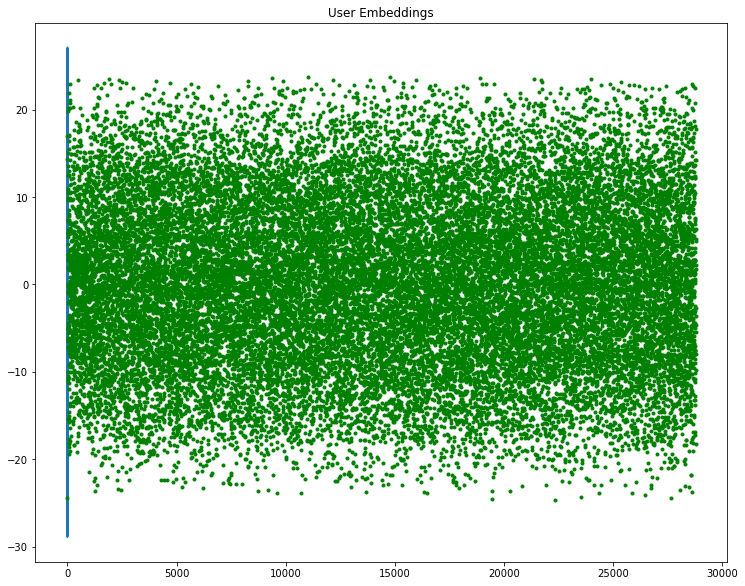

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/matplotlib/collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


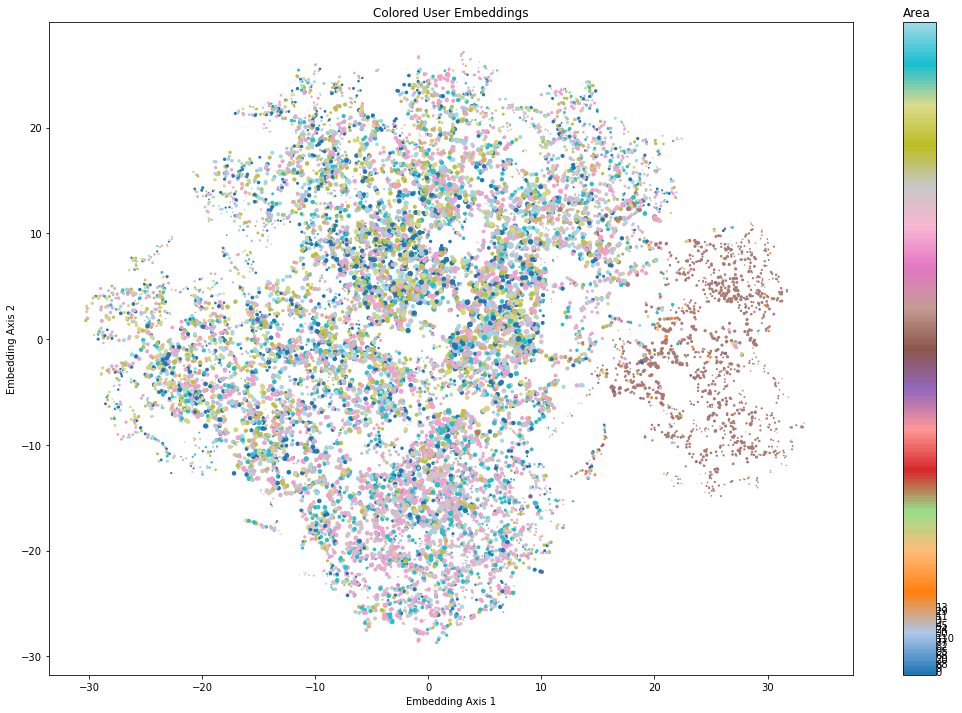

In [27]:
#plot the user embeddings by area
visualize_embeddings(user_embeddings, 'Area', student, num_user_features, 'User')

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


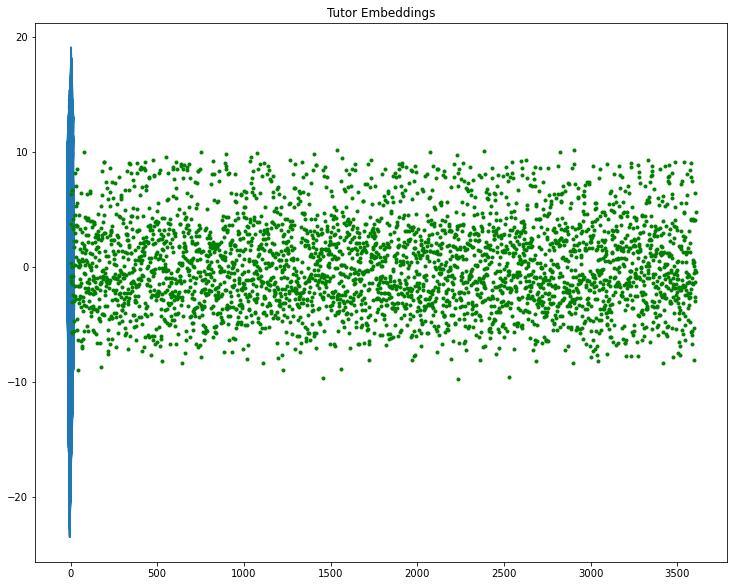

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/matplotlib/collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


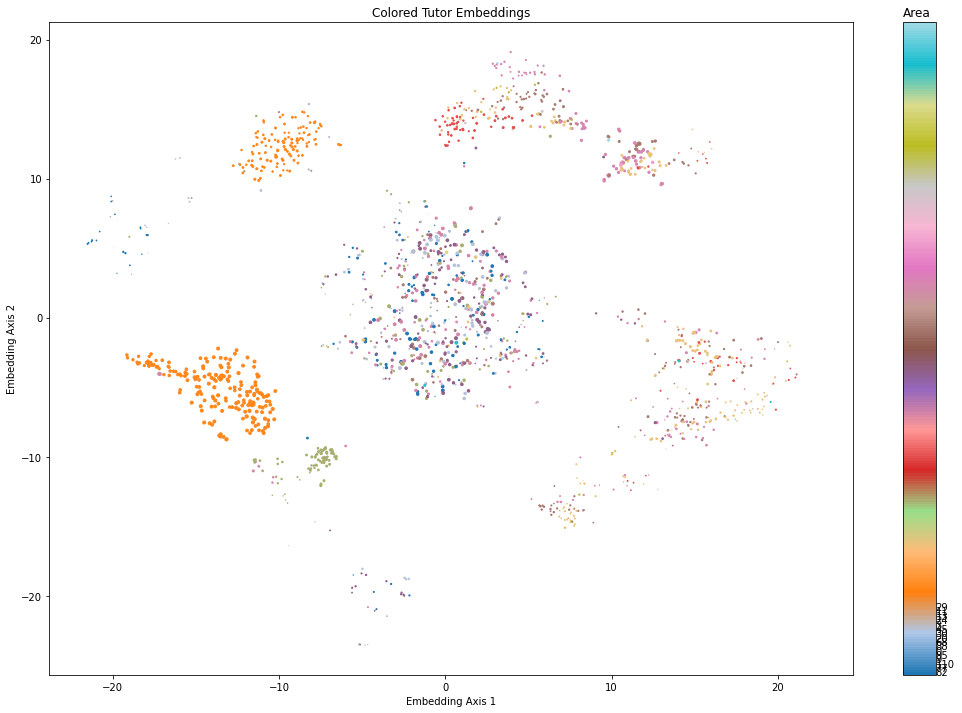

In [28]:
#visualize tutor embeddings
visualize_embeddings(tutor_embeddings, 'Area', rating, num_tutor_features, 'Tutor')